# Analyse Business — Modèles linéaires (v2)

Ce notebook teste des modèles linéaires (Régression linéaire, transformation logarithmique, Ridge) sur le sous-ensemble Business, pour comparer leurs performances avec le modèle Random Forest de l'analyse principale.

L'objectif est de vérifier si un modèle plus simple peut capturer la relation entre les variables et le prix sur ce segment.

In [1]:
import numpy as np
import pandas as pd
import sklearn
 
# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot

# Prétraitement
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
 
# Prétraitement
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
 
# Modèles de Machine Learning
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn import set_config
import joblib
from sklearn.tree import export_text
 
# Évaluation des modèles
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    mean_squared_error,
    r2_score
)

In [2]:
data = pd.read_csv("Clean_Dataset.csv")

data = data[data['class_ticket'] != 'Economy']
data.drop(columns=['class_ticket'], inplace=True)

print(data.head(10))

column_nan_count = data.isnull().sum()
print("NaN count per column:")
print(column_nan_count)

        Unnamed: 0    airline  flight source_city departure_time stops  \
206666      206666  Air_India  AI-868       Delhi        Evening  zero   
206667      206667  Air_India  AI-624       Delhi        Evening  zero   
206668      206668  Air_India  AI-531       Delhi        Evening   one   
206669      206669  Air_India  AI-839       Delhi          Night   one   
206670      206670  Air_India  AI-544       Delhi        Evening   one   
206671      206671    Vistara  UK-985       Delhi        Evening  zero   
206672      206672  Air_India  AI-479       Delhi          Night   one   
206673      206673  Air_India  AI-473       Delhi        Evening   one   
206674      206674    Vistara  UK-871       Delhi          Night   one   
206675      206675    Vistara  UK-977       Delhi        Evening  zero   

       arrival_time destination_city  duration  days_left  price  
206666      Evening           Mumbai      2.00          1  25612  
206667        Night           Mumbai      2.25     

In [3]:
print(data.describe())

          Unnamed: 0      duration     days_left          price
count   93487.000000  93487.000000  93487.000000   93487.000000
mean   253409.000000     13.704274     25.741857   52540.081124
std     26987.516645      6.852555     13.626538   12969.314606
min    206666.000000      1.000000      1.000000   12000.000000
25%    230037.500000      8.830000     14.000000   45185.000000
50%    253409.000000     13.080000     26.000000   53164.000000
75%    276780.500000     17.830000     38.000000   60396.000000
max    300152.000000     47.750000     49.000000  123071.000000


In [4]:
print(data.info())

<class 'pandas.DataFrame'>
RangeIndex: 93487 entries, 206666 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        93487 non-null  int64  
 1   airline           93487 non-null  str    
 2   flight            93487 non-null  str    
 3   source_city       93487 non-null  str    
 4   departure_time    93487 non-null  str    
 5   stops             93487 non-null  str    
 6   arrival_time      93487 non-null  str    
 7   destination_city  93487 non-null  str    
 8   duration          93487 non-null  float64
 9   days_left         93487 non-null  int64  
 10  price             93487 non-null  int64  
dtypes: float64(1), int64(3), str(7)
memory usage: 12.0 MB
None


# Colonnes :
- `Unnamed: 0` : index technique, à supprimer
- `airline` : nom de la compagnie aérienne (catégorielle, 6 compagnies)
- `flight` : code de vol, à supprimer (trop spécifique, inutile pour la prédiction)
- `source_city` : ville de départ (catégorielle, 6 villes)
- `departure_time` : créneau de départ ("Early_Morning", "Morning", "Afternoon", "Evening", "Night")
- `stop` : nombre d'escales (0, 1, 2+)
- `arrival_time` : créneau d'arrivée ("Early_Morning", "Morning", "Afternoon", "Evening", "Night")
- `destination_city` : ville d'arrivée (catégorielle, 6 villes)
- `class_ticket` : classe de voyage ("Business", "Economy")
- `duration` : durée totale du vol en heures (numérique)
- `days_left` : jours restants avant le départ (numérique)
- `price` : prix du billet en roupies indiennes — **variable cible**

In [5]:
df = data.drop(columns=['Unnamed: 0'], inplace=False)
df = df.drop(columns=['flight'], inplace=False)
# df = df.drop(columns=['airline'], inplace=False)

## Duplicates et valeurs manquantes

In [6]:
duplicate_count = df.duplicated().sum()
missing_values = df.isnull().sum()

df.drop_duplicates(inplace=True)
print(f"Nombre de doublons supprimés : {duplicate_count}")
print("Valeurs manquantes par colonne :")
print(missing_values)

Nombre de doublons supprimés : 314
Valeurs manquantes par colonne :
airline             0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
duration            0
days_left           0
price               0
dtype: int64


### Graphes pour visualiser les valeurs aberrantes et la distribution des données

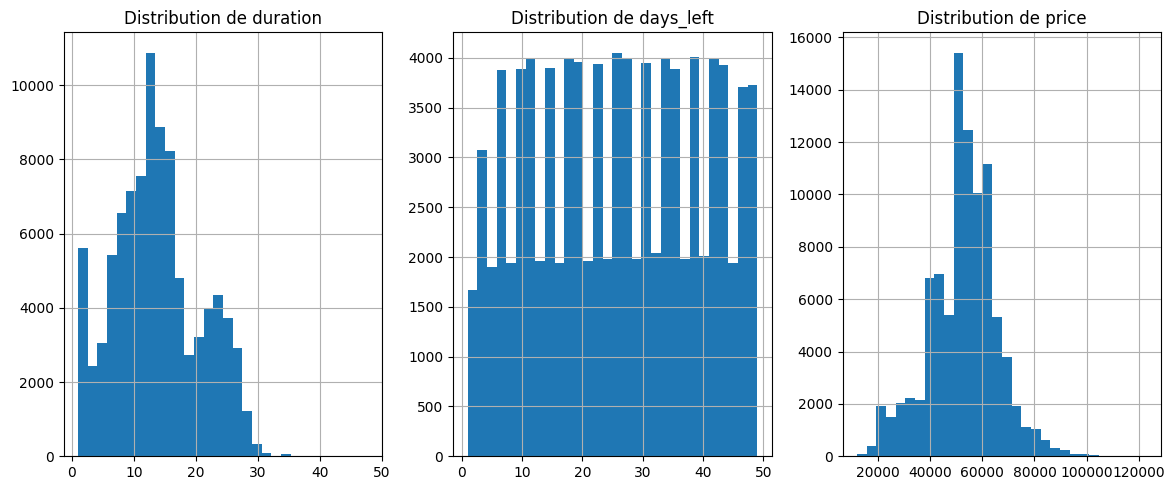

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
df.hist(column='duration', bins=30, ax=axes[0])
df.hist(column='days_left', bins=30, ax=axes[1])
df.hist(column='price', bins=30, ax=axes[2])
axes[0].set_title('Distribution de duration')
axes[1].set_title('Distribution de days_left')
axes[2].set_title('Distribution de price')
plt.tight_layout()
plt.show()

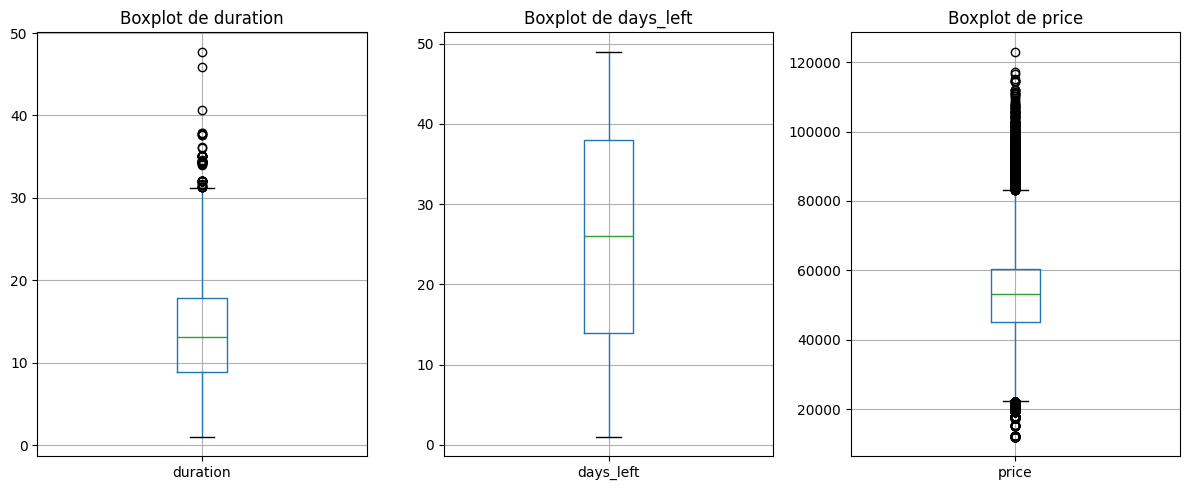

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
df.boxplot(column='duration', ax=axes[0])
df.boxplot(column='days_left', ax=axes[1])
df.boxplot(column='price', ax=axes[2])
axes[0].set_title('Boxplot de duration')
axes[1].set_title('Boxplot de days_left') 
axes[2].set_title('Boxplot de price') 
plt.tight_layout()
plt.show()

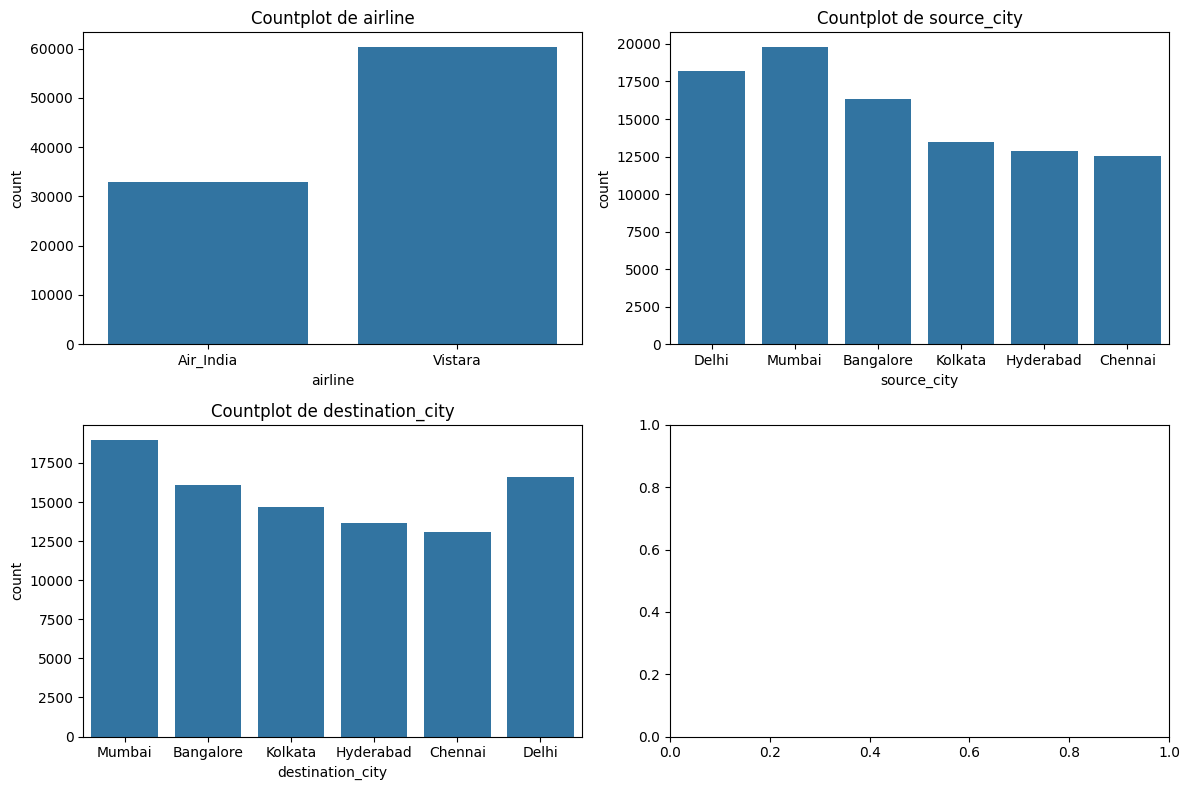

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.countplot(x=df['source_city'], ax=axes[0, 1])
axes[0, 1].set_title('Countplot de source_city')
sns.countplot(x=df['destination_city'], ax=axes[1, 0])
axes[1, 0].set_title('Countplot de destination_city')
sns.countplot(x=df['airline'], ax=axes[0, 0])
axes[0, 0].set_title('Countplot de airline')
plt.tight_layout()
plt.show()

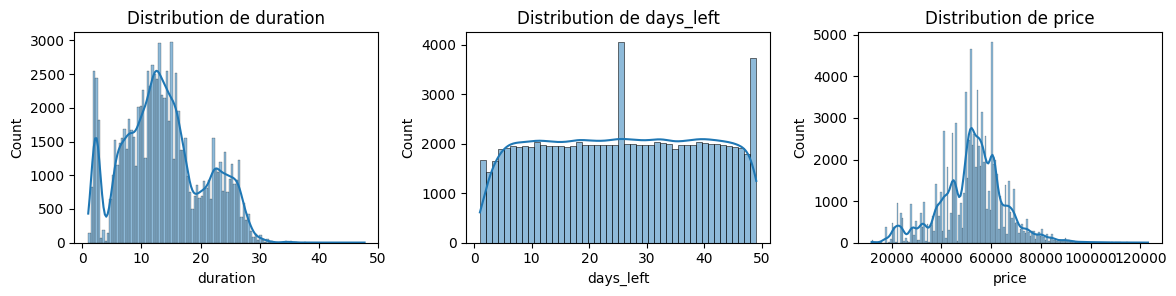

In [10]:
df_num = df.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 8))
for i, column in enumerate(df_num.columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df_num[column], kde=True)
    plt.title(f'Distribution de {column}')
plt.tight_layout()
plt.show()

Corrélation avec encodage OrdinalEncoder et OneHotEncoder pour inclure les variables catégorielles dans la matrice de corrélation.

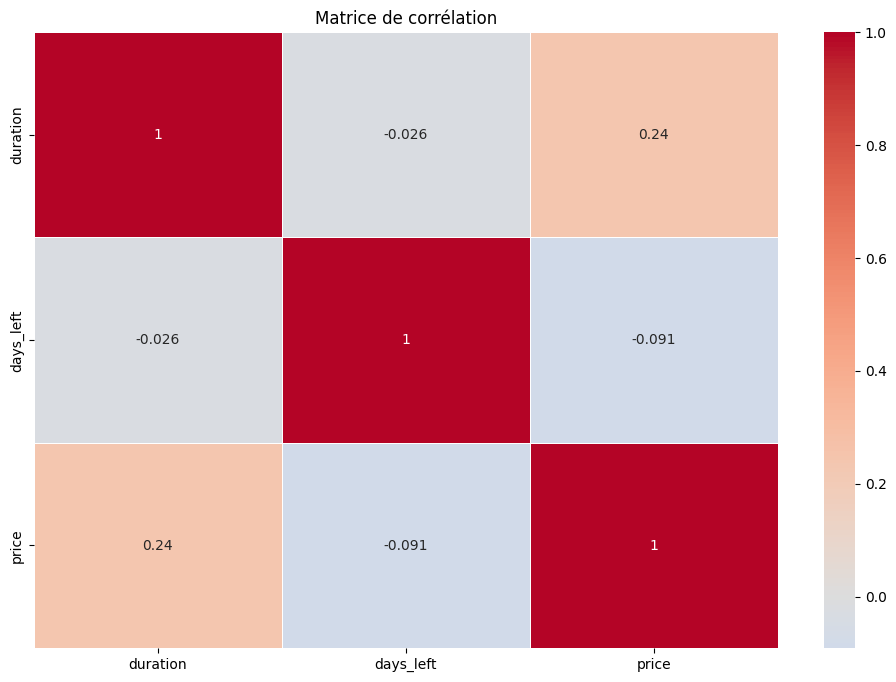

In [11]:
df_num = df.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 8))
sns.heatmap(df_num.corr(), annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Matrice de corrélation')
plt.show()

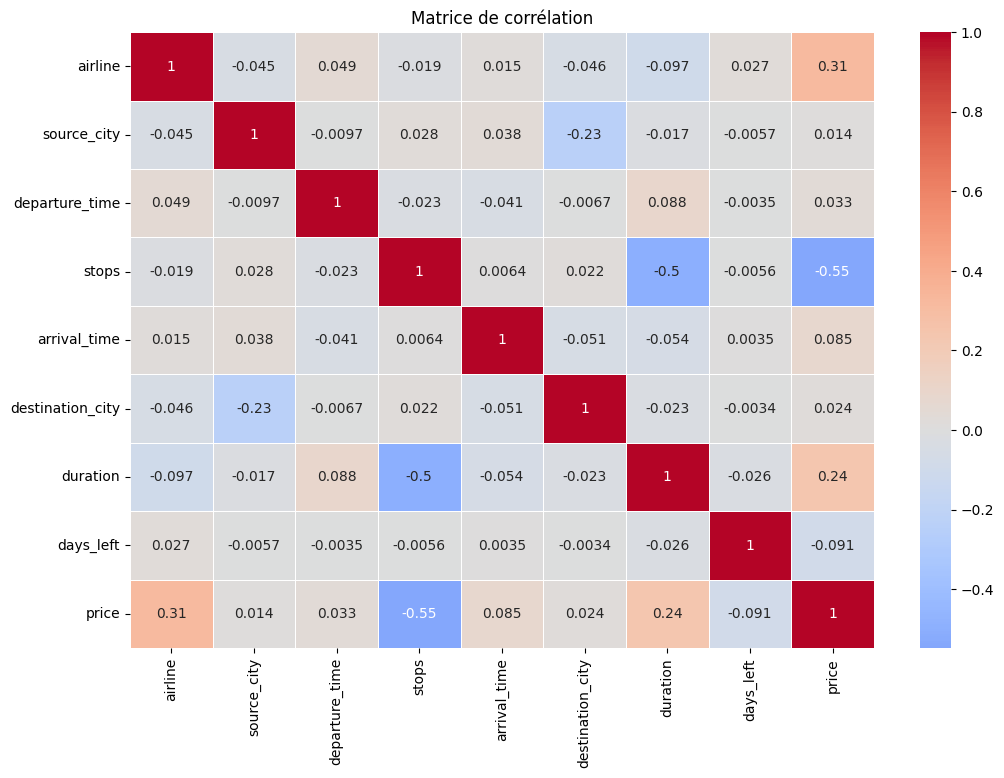

In [14]:
df2 = df.copy()
#encode les variables catégorielles using ordinal encoder
categorical_cols = df2.select_dtypes(include=['object', 'string']).columns
for col in categorical_cols:
    le = OrdinalEncoder()
    df2[col] = le.fit_transform(df2[[col]])

plt.figure(figsize=(12, 8))
sns.heatmap(df2.corr(), annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Matrice de corrélation')
plt.show()

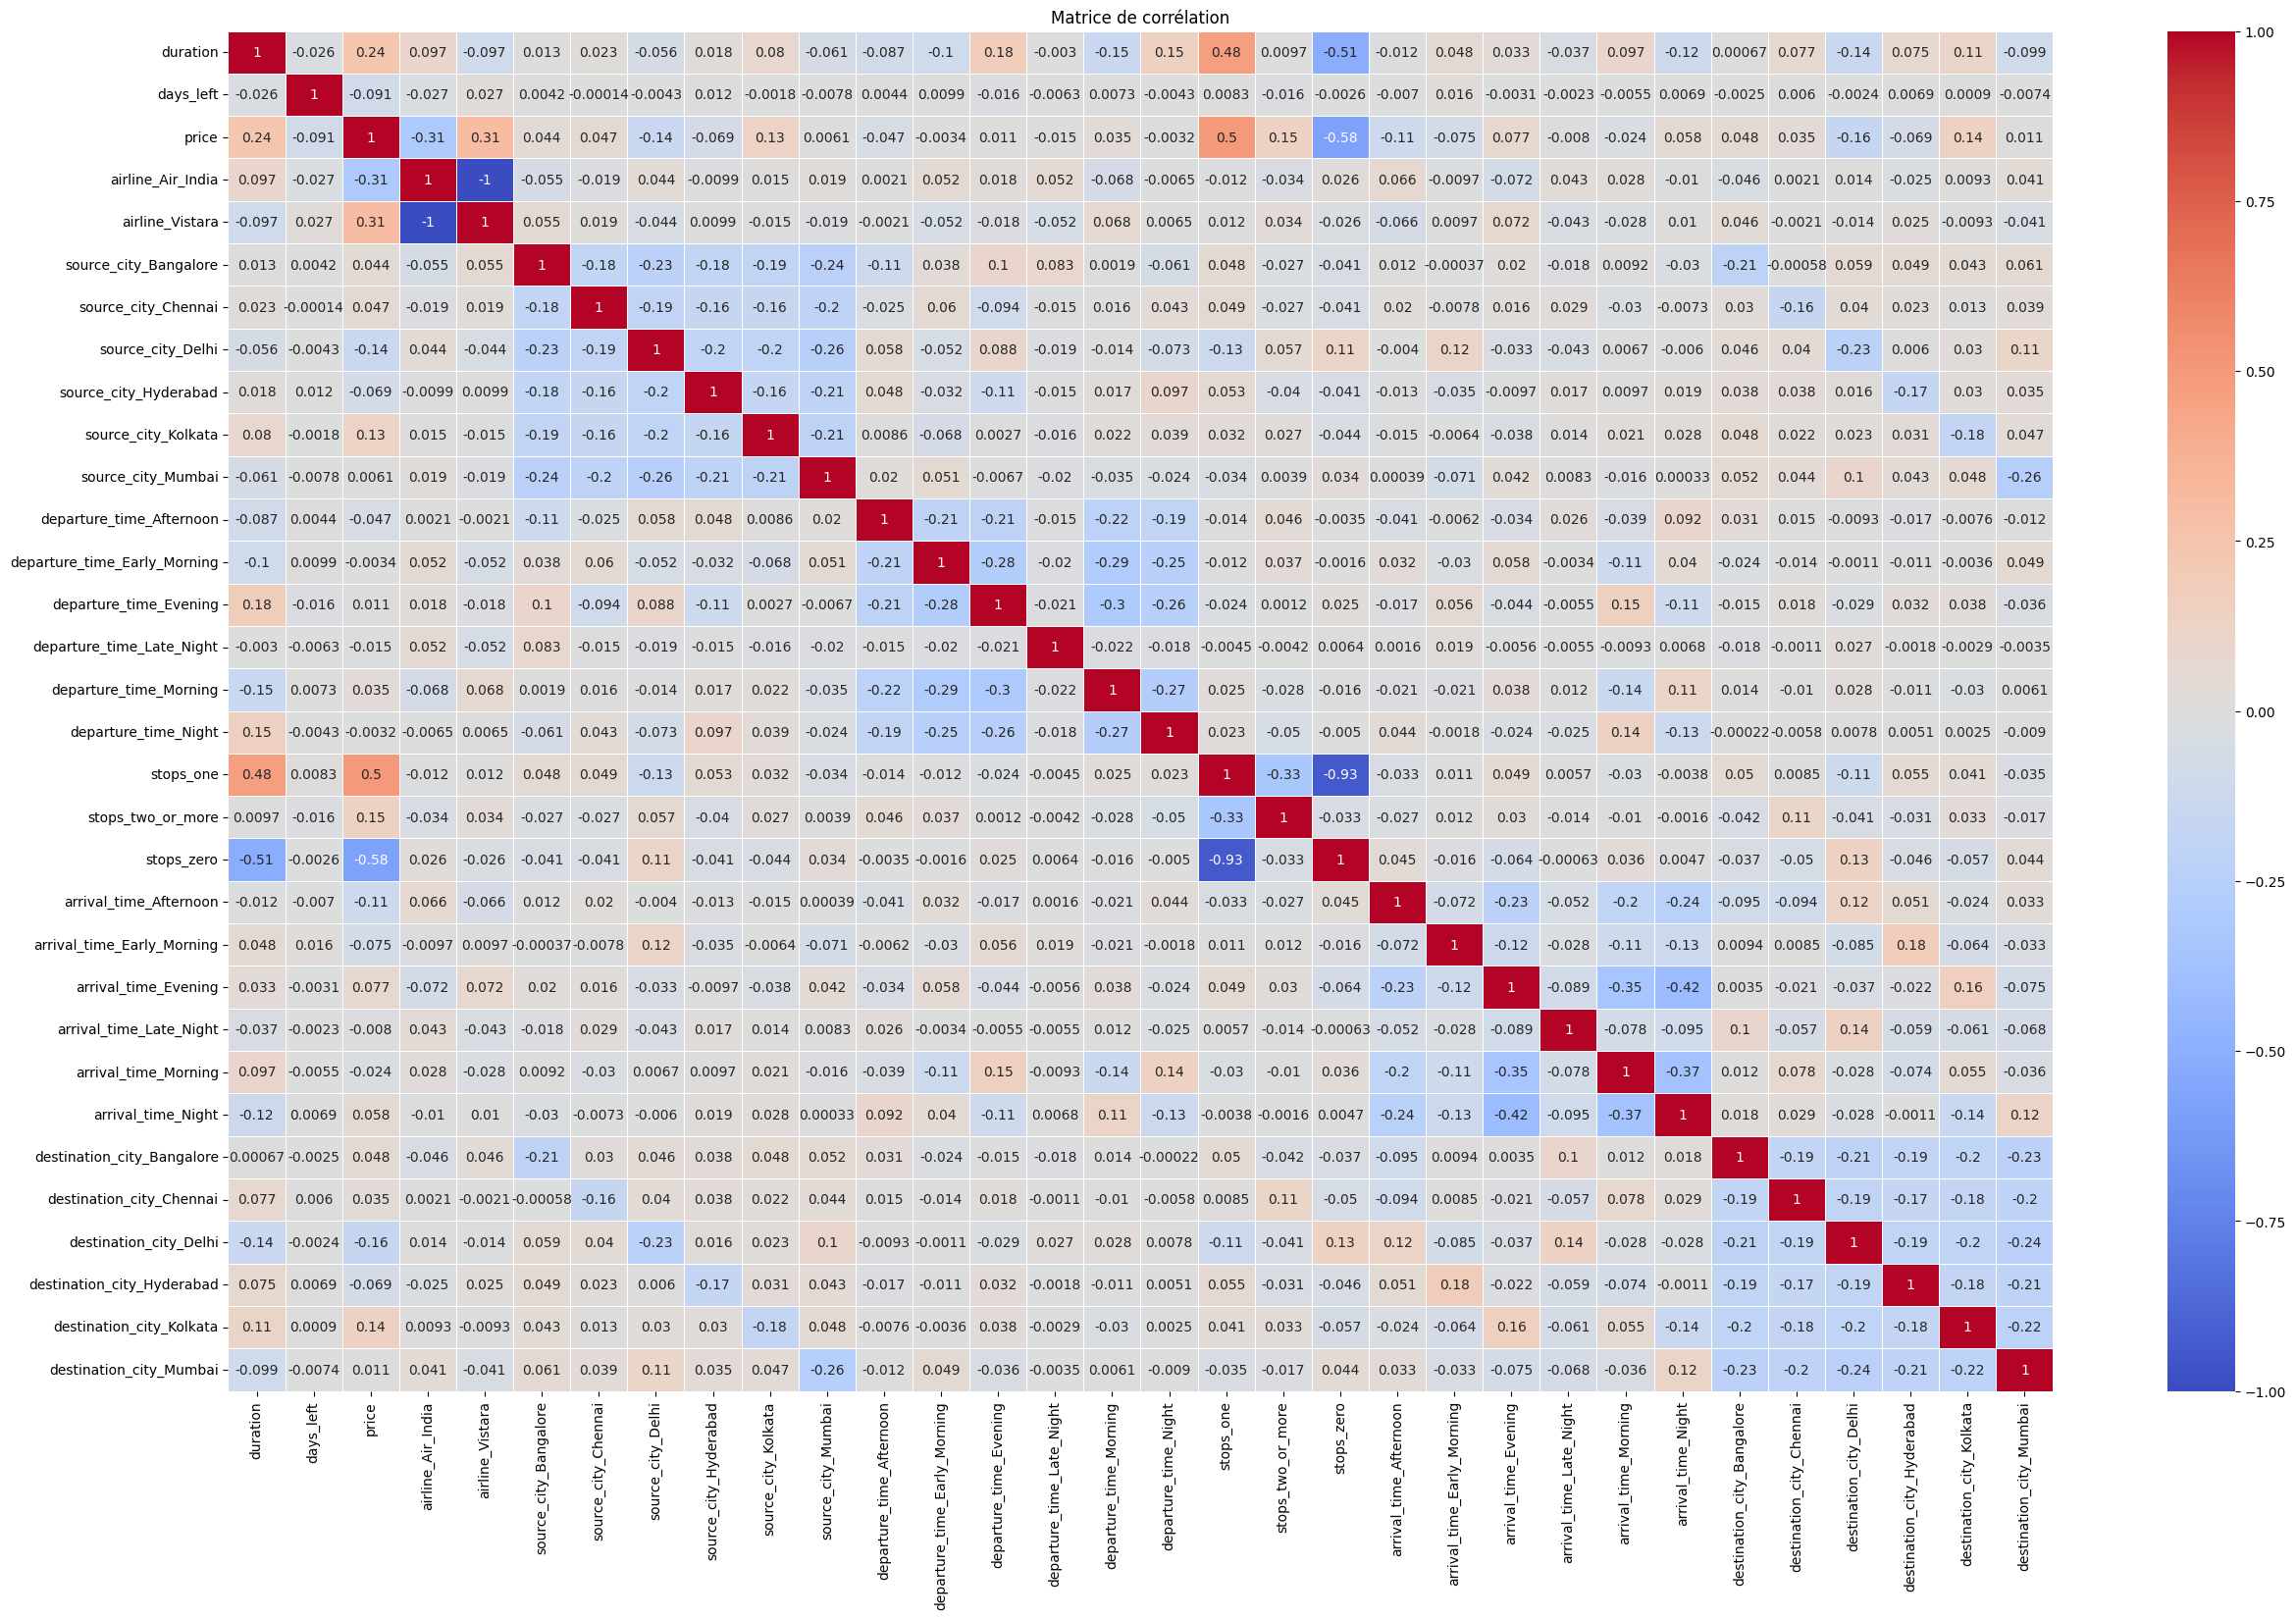

In [24]:
df3 = df.copy()
#encode les variables catégorielles using one hot encoder
categorical_cols = df3.select_dtypes(include=['object', 'string', 'category']).columns
df3 = pd.get_dummies(df3, columns=categorical_cols)

plt.figure(figsize=(30, 18))
sns.heatmap(df3.corr(), annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Matrice de corrélation')
plt.show()

In [16]:
print(df.columns)

Index(['airline', 'source_city', 'departure_time', 'stops', 'arrival_time',
       'destination_city', 'duration', 'days_left', 'price'],
      dtype='str')


In [17]:
X = df.drop(columns=['price'])
y = df['price']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

 ## Linear Regression

In [19]:
lr = LinearRegression()

pipeline_lr = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ['duration', 'days_left']),
            ('cat', OneHotEncoder(handle_unknown='ignore'), ['source_city', 'destination_city', 'airline'])
        ]
    )),
    ('model', lr)
])
set_config(display='diagram')

pipeline_lr.fit(X_train, y_train)

y_pred_lr = pipeline_lr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2 = r2_score(y_test, y_pred_lr)

print(f"Linear Regression - RMSE: {rmse:.2f}")
print(f"Linear Regression - R²: {r2:.2f}")

pipeline_lr

Linear Regression - RMSE: 11091.87
Linear Regression - R²: 0.27


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

La régression linéaire atteint un R² ≈ 0.22, ce qui est très faible. Cela indique que la relation entre les variables et le prix n'est pas linéaire, et que les interactions entre les caractéristiques sont importantes pour expliquer la variabilité des prix.

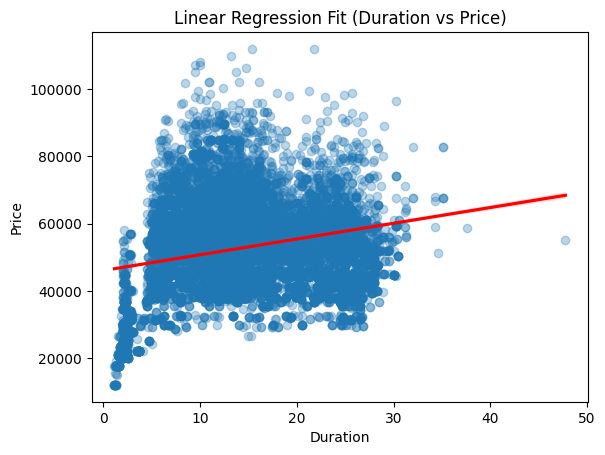

In [20]:
sns.regplot(x=X_test['duration'], y=y_test, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.xlabel("Duration")
plt.ylabel("Price")
plt.title("Linear Regression Fit (Duration vs Price)")
plt.show()

Le modèle linéaire fonctionne mieux quand peu de variables ont une relation linéaire avec la variable cible. Ici, les prix des billets sont influencés par de nombreux facteurs complexes et non linéaires (saisonnalité, demande, promotions, etc.).

Sur le graphique, la durée du vol augmente légèrement avec le prix, mais beaucoup de points sont très éloignés de la ligne de régression, ce qui confirme que le modèle linéaire ne capture pas bien cette relation.

## Log transformation

In [21]:
y_log = np.log1p(y)

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)


X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

pipeline_lr.fit(X_train, y_train_log)

y_pred_log = pipeline_lr.predict(X_test)

# Convert back
y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test_log)

rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
r2 = r2_score(y_test_original, y_pred)

print("RMSE (log model):", rmse)
print("R² (log model):", r2)

RMSE (log model): 11389.972889280834
R² (log model): 0.22788153814123668


On applique une transformation logarithmique pour corriger une éventuelle asymétrie, mais cela n'améliore pas les performances. Les données ont une skewness assez faible, donc la transformation n'est pas nécessaire ici.

## Ridge Regression

In [22]:
ridge = Ridge(alpha=1.0)

pipeline_ridge = Pipeline(steps=[
    ("preprocessor", ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), ['duration', 'days_left']),
            ("cat", OneHotEncoder(handle_unknown='ignore'), ['source_city', 'destination_city', 'airline'])
        ]
    )),
    ("model", ridge)
]) 

pipeline_ridge.fit(X_train, y_train_log)
y_pred_ridge_log = pipeline_ridge.predict(X_test)
y_pred_ridge = np.expm1(y_pred_ridge_log)
rmse_ridge = np.sqrt(mean_squared_error(y_test_original, y_pred_ridge))
r2_ridge = r2_score(y_test_original, y_pred_ridge)
print("Ridge Regression - RMSE:", rmse_ridge)
print("Ridge Regression - R²:", r2_ridge)

pipeline_ridge

Ridge Regression - RMSE: 11389.96288130316
Ridge Regression - R²: 0.22788289500854575


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

La Ridge Regression est une variante de la régression linéaire qui prend en compte la multi-colinéarité entre les variables. Elle améliore légèrement les performances par rapport à la régression linéaire simple, mais n'atteint pas une performance significative (R² ≈ 0.22). Ce résultat confirme que les modèles linéaires ne sont pas adaptés pour ce type de données.

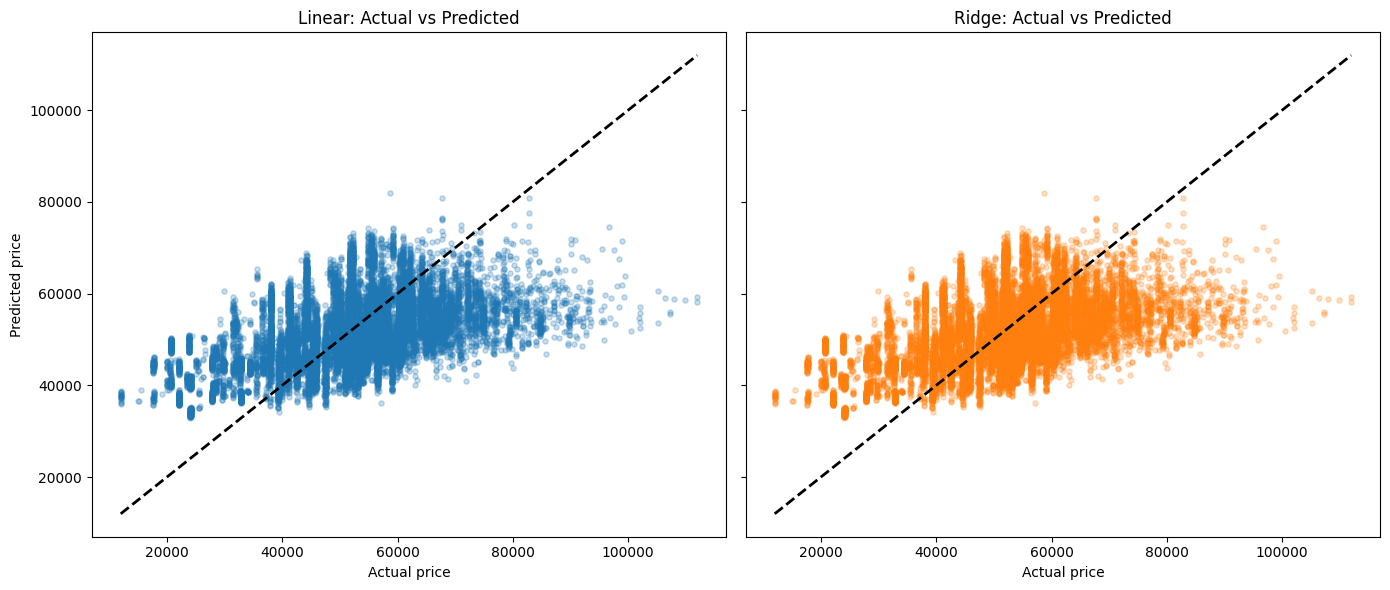

In [23]:
y_true_plot = y_test_original if 'y_test_original' in globals() else y_test

y_pred_linear_plot = y_pred if 'y_pred' in globals() else y_pred_lr
y_pred_ridge_plot = y_pred_ridge

min_v = min(y_true_plot.min(), y_pred_linear_plot.min(), y_pred_ridge_plot.min())
max_v = max(y_true_plot.max(), y_pred_linear_plot.max(), y_pred_ridge_plot.max())

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

axes[0].scatter(y_true_plot, y_pred_linear_plot, alpha=0.25, s=14, color='tab:blue')
axes[0].plot([min_v, max_v], [min_v, max_v], 'k--', linewidth=2)
axes[0].set_title('Linear: Actual vs Predicted')
axes[0].set_xlabel('Actual price')
axes[0].set_ylabel('Predicted price')

axes[1].scatter(y_true_plot, y_pred_ridge_plot, alpha=0.25, s=14, color='tab:orange')
axes[1].plot([min_v, max_v], [min_v, max_v], 'k--', linewidth=2)
axes[1].set_title('Ridge: Actual vs Predicted')
axes[1].set_xlabel('Actual price')

plt.tight_layout()
plt.show()

Ce graphique compare les prédictions des deux modèles (linéaire et Ridge) par rapport aux valeurs réelles. Les points sur la diagonale correspondent aux bonnes prédictions. Au-dessus : surestimation. En dessous : sous-estimation. Le R² ≈ 0.27 confirme les mauvaises performances des modèles linéaires.

## Conclusion

La régression linéaire ne parvient pas à capturer la nature non linéaire de la tarification aérienne, ce qui se traduit par une faible performance (R² ≈ 0.22). La transformation logarithmique n'améliore pas les résultats, car les données ont une asymétrie faible. La Ridge Regression donne un résultat similaire (R² ≈ 0.22), ce qui confirme que les modèles linéaires ne sont pas adaptés pour ce type de données.

En revanche, les modèles Random Forest de l'analyse v1 (Economy et Business) atteignent une performance bien supérieure (R² ≈ 0.88), ce qui confirme la structure complexe et non linéaire de la tarification des vols.